# Download Data from Copernicus Open Access Hub

The data source for Sentinel-2 data we use is the Copernicus Open Access Hub.
Please create an account first:

https://scihub.copernicus.eu/dhus/#/self-registration

In [1]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import os

API access is set up using environment variables. Configure `SCIHUB_USERNAME` and `SCIHUB_PASSWORD` should contain the credentials of your account in order to gain access to the Copernicus Open Access Hub:

In [2]:
api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))

## Defining the Region of Interest

The Copernicus Open Access Hub API expects a point or area that designates the region of interest.
We use the [OpenStreetMap Nominatim API](https://nominatim.org/) to query for the administrative boundaries of Berlin using the `search_osm` function defined in `sentinel_helpers.py`:

In [3]:
from sentinel_helpers import search_osm

In [4]:
??search_osm

Signature: search_osm(place)
Source:   
def search_osm(place):
    '''
    Returns a GeoDataFrame with results from OpenStreetMap Nominatim for the given search string.
    This allows us to fetch detailed geometries for virtually any place on earth.
    '''
    urlescaped_place = urllib.parse.quote(place)
    search_url = ('https://nominatim.openstreetmap.org/search/?q={}' +
                  '&format=geojson&polygon_geojson=1').format(urlescaped_place)
    return gpd.read_file(search_url)
File:      ~/true-color-image/sentinel_helpers.py
Type:      function


In [5]:
results = search_osm('Berlin, Germany')
results.head()

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,574401,node,240109189,"Berlin, 10117, Deutschland",15,place,city,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,POINT (13.38886 52.51704)
1,256375666,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((13.08835 52.41963, 13.09021 52..."
2,1253688,node,313826576,"Berlin, Tauentzienstraße, Charlottenburg, Char...",30,tourism,artwork,0.315372,https://nominatim.openstreetmap.org/ui/mapicon...,POINT (13.33864 52.50340)
3,225671,node,50798110,"Berlin, Seedorf, Trave-Land, Segeberg, Schlesw...",19,place,village,0.272651,https://nominatim.openstreetmap.org/ui/mapicon...,POINT (10.44613 54.03636)
4,107621118,way,68276545,"Berlin, Potsdam, Klein Bennebek, Kropp-Stapelh...",26,highway,unclassified,0.210000,None,"LINESTRING (9.41929 54.40283, 9.42072 54.40343..."


OpenStreetMap contains geoinformation at vastly different scales.
We can use it to query outlines of parks or entire countries.
Using the `search_osm` function we are very flexible in the type of query information we can retrieve.

The first result is the city's centroid. We use the `type` to select the administrative boundaries.

<AxesSubplot:>

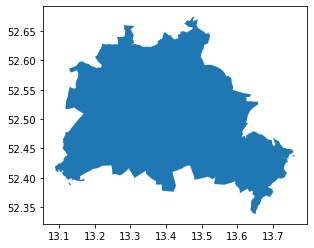

In [6]:
berlin = results[results['type'] == 'administrative']
berlin.plot()

In [7]:
berlin.to_file('./input/berlin.geojson', driver='GeoJSON')

## Querying the API

Other query parameters that are useful are the time span for which we would like to retrieve images and the maximum cloud coverage we want the imges to have:

In [8]:
from datetime import date
import datetime

In [9]:
start_date = date(2020, 5, 22)
end_date = date(2020, 6, 22)
cloud_coverage = (0,30) # between 0 and 30 percent

The region of interest is given as the `footprint` parameter.
We use the bounding box of the geometry retrieved from OpenStreetMap due to restrictions in the URL length that don't allow us to query for arbitrarily detailed geometries:

In [10]:
from shapely.geometry import box
footprint = box(*berlin.iloc[0]['geometry'].bounds)

In [11]:
products = api.query(footprint,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(start_date, end_date),
                     cloudcoverpercentage=cloud_coverage)

How many results do we have?

In [12]:
print(f'Found {len(products)} results')

Found 16 results


## Selecting Products from the Result Set

The criteria for selecting a product depends on the specific use case.
Because our current use case is only to plot an image of Berlin, we want to make sure that the city is completely covered by the resulting product.

We convert the list of products to a `GeoPandas` `GeoDataFrame`:

In [13]:
products = api.to_geodataframe(products)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


The `plot_all` function is a helper that allows us to draw several geometries on top of each other in a single plot.
We can use it to get a quick visual impression of the result:

In [14]:
from sentinel_helpers import plot_all
import matplotlib.pyplot as plt
%matplotlib inline

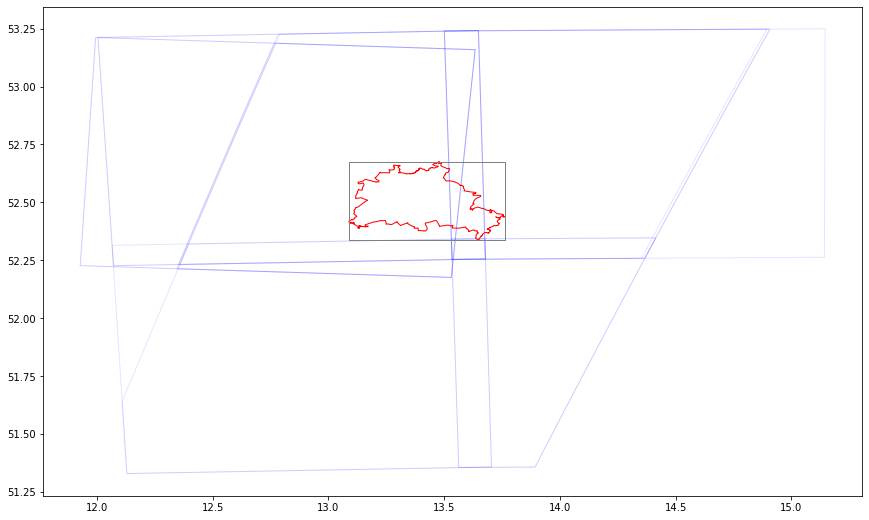

In [15]:
plot_all([products, berlin, footprint],
         [{'color': 'none', 'edgecolor': 'blue', 'alpha': 0.1, 'figsize': (16, 9)},
          {'color': 'none', 'edgecolor': 'red'},
          {'color': 'none', 'edgecolor': 'grey'}])

<div class="alert alert-primary" role="alert">
    <b>Note:</b> The geometrical shape of the captured data a product depends on where a Sentinel-2 satellite was in orbit when it crossed the area of interest.
    An in-depth analysis for this can be found in <code>01b Coverage Analysis.ipynb</code>.
</div>

Because downloads are large, we skip unnecessary downloads wherever possible.

- For this particular example we can select exactly one
- 


- Select biggest intersection area
- Figure out which tiles are needed 


In [16]:
# we are using a metric coordinate reference system for europe in order to
# safely compare areas 
products = products.to_crs('EPSG:4839')
berlin = berlin.to_crs('EPSG:4839')

In [17]:
import geopandas as gpd

In [18]:
intersection = gpd.overlay(
    products,
    berlin,
    how="intersection"
)

In [19]:
intersection['area'] = intersection['geometry'].area
max_area = max(*intersection['area'])
largest_intersections = intersection[intersection['area'] == max_area]
largest_intersections

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,...,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry,area
1,S2A_MSIL2A_20200617T101031_N0214_R022_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-06-17T10:10:31.024Z, Instrument: MS...",false,2020-06-17 10:10:31.024,2020-06-17 10:10:31.024,2020-06-17 21:35:56.836,26045,...,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((215331.937 168288.512, 216047....",8.535962e+08
3,S2B_MSIL2A_20200615T101559_N0214_R065_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-06-15T10:15:59.024Z, Instrument: MS...",false,2020-06-15 10:15:59.024,2020-06-15 10:15:59.024,2020-06-16 01:21:09.378,17108,...,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((215331.937 168288.512, 216047....",8.535962e+08
10,S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-06-02T10:05:59.024Z, Instrument: MS...",false,2020-06-02 10:05:59.024,2020-06-02 10:05:59.024,2020-06-02 18:40:43.331,16922,...,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((215331.937 168288.512, 216047....",8.535962e+08
11,S2A_MSIL2A_20200531T102031_N0214_R065_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-05-31T10:20:31.024Z, Instrument: MS...",false,2020-05-31 10:20:31.024,2020-05-31 10:20:31.024,2020-05-31 20:21:27.279,25802,...,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((215331.937 168288.512, 216047....",8.535962e+08


In [25]:
largest_intersections[['title', 'cloudcoverpercentage']]

,title,cloudcoverpercentage
1,S2A_MSIL2A_20200617T101031_N0214_R022_T33UUU_2...,24.374344
3,S2B_MSIL2A_20200615T101559_N0214_R065_T33UUU_2...,3.626466
10,S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_2...,0.345483
11,S2A_MSIL2A_20200531T102031_N0214_R065_T33UUU_2...,16.512980


Let's download all of these `input/raster/true_color_image`.
Repeated calls to `download` or `download_all` will skip the download process if a product has previously been downloaded.

In [20]:
from pathlib import Path
dst_path = Path('input/raster/true_color_image')

# create the path if it doesn't exist
! mkdir -p {dst_path}

In [21]:
from sentinel_helpers import scihub_product_ids

In [22]:
downloads = api.download_all(scihub_product_ids(largest_intersections), dst_path)
downloads

({'b64d4450-d999-41dc-9ecb-6d263f322dd3': {'id': 'b64d4450-d999-41dc-9ecb-6d263f322dd3',
   'title': 'S2B_MSIL2A_20200615T101559_N0214_R065_T33UUU_20200615T141117',
   'size': 1176239030,
   'md5': '86D9DB1D0C6C087D66AE28E4A106EF04',
   'date': datetime.datetime(2020, 6, 15, 10, 15, 59, 24000),
   'footprint': 'POLYGON((12.004760925069467 53.21197782662703,13.648341514492438 53.24196354764364,13.678544065009483 52.25515074878083,12.071595116334858 52.22621087043558,12.004760925069467 53.21197782662703))',
   'url': "https://scihub.copernicus.eu/apihub/odata/v1/Products('b64d4450-d999-41dc-9ecb-6d263f322dd3')/$value",
   'Online': True,
   'Creation Date': datetime.datetime(2020, 6, 16, 1, 22, 2, 573000),
   'Ingestion Date': datetime.datetime(2020, 6, 16, 1, 21, 9, 378000),
   'path': 'input/raster/true_color_image/S2B_MSIL2A_20200615T101559_N0214_R065_T33UUU_20200615T141117.zip',
   'downloaded_bytes': 0},
  '958ef7fc-815e-47c6-b323-219de6a91339': {'id': '958ef7fc-815e-47c6-b323-219de

In [23]:
downloaded_bytes_total = sum(p['downloaded_bytes'] for p in downloads[0].values())
print(f'Downloaded {(downloaded_bytes_total / 1024 ** 3):.2f}GB')

Downloaded 0.00GB
